## Homework #2

In [8]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

url = r'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

data = pd.read_csv(url)
data.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [2]:
# Save a copy of the csv to data folder
ROOT_DIR = Path(os.getcwd())

data.to_csv(ROOT_DIR /'data/laptops.csv')


In [9]:
data.columns = data.columns.str.lower().str.replace(' ','_')

In [10]:
data.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [11]:
df = data[['ram','storage','screen','final_price']].copy()
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


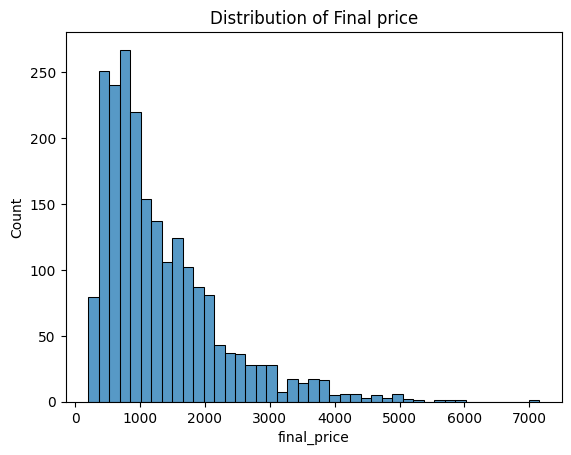

In [12]:
sns.histplot(df.final_price)
plt.title("Distribution of Final price")
plt.show()

Q1) Column 'screen' has missing values

In [7]:
#1

df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

Q2) Median for variable 'ram'  = 16

In [8]:
df.ram.median()

np.float64(16.0)

Prep

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [10]:
def create_train_test_val(df, rs=42):
    df = df.sample(frac=1.0, random_state=rs, ignore_index=True)
    train, test = train_test_split(df, test_size=0.4, random_state=rs)
    test, val = train_test_split(test, test_size=0.5, random_state=rs)
    y_train = train['final_price'].values
    X_train = train.drop(columns='final_price')

    y_test = test['final_price'].values
    X_test = test.drop(columns='final_price')

    y_val = val['final_price'].values
    X_val = val.drop(columns='final_price')

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

    return X_train, y_train, X_test, y_test, X_val, y_val

    



Q3) RMSE with fill of 0 vs RMSE with mean fill

filling with 0 seems to be slightly better

In [11]:
X_train, y_train, X_test, y_test, X_val, y_val = create_train_test_val(df, rs = 42)

(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)


In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX) 
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [14]:
cols = ['ram','storage','screen','final_price']

train_X_means = X_train.mean()
train_X_means

ram         15.129630
storage    589.135802
screen      15.161872
dtype: float64

In [15]:
X_train.isna().sum()

ram        0
storage    0
screen     3
dtype: int64

In [16]:
X_train[X_train.screen.isna()]

,ram,storage,screen
1564,16,512,NaN
1062,16,512,NaN
1238,8,256,NaN


In [17]:
def prep_X(df, means, method='mean'):
    if method=='mean':
        df = df.fillna(means)
    else:
        df = df.fillna(0)
    return df

In [18]:
def rmse(y, y_pred):
    err = y - y_pred
    sqrederror = err**2
    mse = np.mean(sqrederror)
    return np.sqrt(mse)

In [19]:


def run_lr(X_train, y_train, X_val, y_val, train_means, fillmethod, reg=None):
    X_train = prep_X(X_train, means=train_means, method=fillmethod)
    X_val = prep_X(X_val,  means=train_means, method=fillmethod)  
    if reg is None:
        w0, w = train_linear_regression(X_train, y_train)
    else: 
        w0, w = train_linear_regression_reg(X_train, y_train, r=reg)
    y_pred = w0 + X_val.dot(w)     
    rmse_ = round(rmse(y_val, y_pred),2)
    
    return rmse_

In [20]:
rmse_vals = {}

for m in ['0','mean']:
    rmse_vals[f'RMSE_fillmethod_{m}'] = run_lr(X_train, y_train, X_val, y_val, train_X_means, m)

print(rmse_vals)    


{'RMSE_fillmethod_0': np.float64(588.23), 'RMSE_fillmethod_mean': np.float64(589.6)}


Q4) Regularized linear regresssion


In [21]:
rmse_vals_q4 = {}
r_vals = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_vals:
    rmse_vals_q4[f'RMSE_reg_lr_{r}'] = run_lr(X_train, y_train, X_val, y_val, train_X_means, fillmethod='0',reg=r)

print(rmse_vals_q4)

{'RMSE_reg_lr_0': np.float64(588.23), 'RMSE_reg_lr_0.01': np.float64(588.22), 'RMSE_reg_lr_0.1': np.float64(588.18), 'RMSE_reg_lr_1': np.float64(587.81), 'RMSE_reg_lr_5': np.float64(586.93), 'RMSE_reg_lr_10': np.float64(586.55), 'RMSE_reg_lr_100': np.float64(586.5)}


In [22]:
rmse_vals_q4_df = pd.DataFrame.from_dict(rmse_vals_q4, orient='index').reset_index()
rmse_vals_q4_df.columns = ['Method','RMSE']
rmse_vals_q4_df.sort_values(by='RMSE', inplace=True)
rmse_vals_q4_df

,Method,RMSE
6,RMSE_reg_lr_100,586.50
5,RMSE_reg_lr_10,586.55
4,RMSE_reg_lr_5,586.93
3,RMSE_reg_lr_1,587.81
2,RMSE_reg_lr_0.1,588.18
1,RMSE_reg_lr_0.01,588.22
0,RMSE_reg_lr_0,588.23


regularization with r = 10 seems to be the ideal one

Q5) Seed options

In [23]:

rmse_q5 = {}
seed_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for sv in seed_vals:
    X_train, y_train, X_test, y_test, X_val, y_val = create_train_test_val(df, rs = sv)
    X_means = X_train.mean()
    result = run_lr(X_train, y_train, X_val, y_val, X_means, fillmethod='0',reg=None)
    rmse_q5[f'RMSE_lr_seed_{sv}'] = result
    print(f"RMSE for seed {sv} is {rmse_q5[f'RMSE_lr_seed_{sv}']}")
    scores.append(result)


print(f"Standard Deviation of the RMSE Scores: {round(np.std(scores),3)}")

(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 0 is 575.34
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 1 is 618.82
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 2 is 591.12
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 3 is 546.25
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 4 is 645.8
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 5 is 634.31
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 6 is 542.8
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 7 is 533.27
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 8 is 576.84
(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
RMSE for seed 9 is 554.53
Standard Deviation of the RMSE Scores: 37.763


In [24]:
rmse_q5_df = pd.DataFrame.from_dict(rmse_q5, orient='index').reset_index()
rmse_q5_df.columns= ['Seed','RMSE']
rmse_q5_df.sort_values(by='RMSE', inplace=True)
rmse_q5_df

,Seed,RMSE
7,RMSE_lr_seed_7,533.27
6,RMSE_lr_seed_6,542.80
3,RMSE_lr_seed_3,546.25
9,RMSE_lr_seed_9,554.53
0,RMSE_lr_seed_0,575.34
8,RMSE_lr_seed_8,576.84
2,RMSE_lr_seed_2,591.12
1,RMSE_lr_seed_1,618.82
5,RMSE_lr_seed_5,634.31
4,RMSE_lr_seed_4,645.80


Q6) Final LR

In [25]:
X_train, y_train, X_test, y_test, X_val, y_val = create_train_test_val(df, rs = 9)
X_train_final = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_final = np.concatenate([y_train, y_val])
X_means = X_train_final.mean()
result = run_lr(X_train_final, y_train_final, X_test, y_test, X_means, fillmethod='0',reg=0.001)

print(f"Final RMSE: {result}")

(1296, 3) (1296,) (432, 3) (432,) (432, 3) (432,)
Final RMSE: 562.72
